In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as functional
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from typing import List
from functools import partial
from pathlib import Path

from transformers import AutoTokenizer, AutoModel

from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.preprocessing import PandasDataPreprocessor
from ptls.frames.coles import ColesDataset, CoLESModule
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import ISeqLenLimit, FeatureFilter
from ptls.nn.trx_encoder.encoders import IdentityEncoder

from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import plot_roc_curve

from pytorch_lightning.loggers import TensorBoardLogger

from lightgbm import LGBMClassifier

In [2]:
data_path = Path('data')
pl.seed_everything(42)
plt.style.use('bmh')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

Global seed set to 42


# Training sequence encoder

creating embeddigns of mcc descriptions

In [3]:
def embed_mcc_descs(mcc_descriptions: List[str], batch_size: int = 10000):
    tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
    bert = AutoModel.from_pretrained('cointegrated/rubert-tiny2').cuda()
    res = dict()
    for i in range(0, len(mcc_descriptions), batch_size):
        descs = mcc_descriptions[i:i+batch_size]
        tokens = tokenizer(descs, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            out = bert(**{k: v.to(bert.device) for k, v in tokens.items()})
        embeddings = functional.normalize(out.last_hidden_state[:, 0, :]).cpu()
        res.update(dict(zip(descs, embeddings)))
    return res

## Data load and preprocessing

In [4]:
joined = pd.read_csv(data_path / 'dataset_aug_syn_03.csv').drop(columns=['mcc_description'])
embs = embed_mcc_descs(joined['aug_mcc_description'].unique().tolist())
joined['aug_mcc_description'] = joined['aug_mcc_description'].apply(lambda description: embs[description])

preprocessor = PandasDataPreprocessor(
    col_id='customer_id',
    col_event_time='event_time',
    event_time_transformation='none',
    cols_category=['tr_type', 'term_id'],
    cols_numerical=['amount'],
    cols_identity=['aug_mcc_description'],
)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
dataset = MemoryMapDataset(
    data=preprocessor.fit_transform(joined),
    i_filters=[
        ISeqLenLimit(max_seq_len=2000),
        FeatureFilter(keep_feature_names='customer_id')
    ]
)

In [6]:
with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

## Train-validation split

In [7]:
TRAIN_SIZE = int(len(dataset) * 0.8)
VAL_SIZE = len(dataset) - TRAIN_SIZE

train, val = torch.utils.data.random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

## Model definition

In [8]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount': 'identity'},
    embeddings={
        'tr_type': {'in': 100, 'out': 24},
    },
    custom_embeddings = {'aug_mcc_description': IdentityEncoder(312)},
    norm_embeddings=False
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=1024,
    type='gru',
    bidir=False,
    trainable_starter='static'
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.002, weight_decay=0.0),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.9025),
)

## Data loaders

In [9]:
train_dl = PtlsDataModule(
    train_data=ColesDataset(
        train,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=15,
            cnt_max=75,
        ),
    ),
    train_num_workers=8,
    train_batch_size=128,
    valid_data=ColesDataset(
        val,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=100
        )
    ),
    valid_batch_size=512,
    valid_num_workers=16
)

## Trainer

In [10]:
trainer = pl.Trainer(
    max_epochs=150,
    accelerator="gpu",
    devices=[1],
    enable_progress_bar=False,
    logger=TensorBoardLogger('lightning_logs', name='exogenous_text_embeddings_syn_aug_05')
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Training

In [11]:
%%time
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 4.2 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.765    Total estimated model params size (MB)
2023-04-05 15:29:02.585014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 15:29:02.744516: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. 

{'loss': tensor(112.2657), 'seq_len': tensor(43.9375), 'recall_top_k': tensor(0.7820)}
CPU times: user 15min 53s, sys: 29min 36s, total: 45min 29s
Wall time: 39min 41s


Model saving

In [12]:
torch.save(model.state_dict(), 'seq_encoder.pt')

# Using embeddings for downstream task

In [13]:
model = torch.load('seq_encoder.pt')

## Inference data loaders

In [14]:
train_dl = torch.utils.data.DataLoader(
    dataset=train,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

val_dl = torch.utils.data.DataLoader(
    dataset=val,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

## Getting user embeddings

In [15]:
inf_model = InferenceModule(
    seq_encoder
)

In [16]:
df_train = pd.concat(trainer.predict(inf_model, train_dl))
df_val = pd.concat(trainer.predict(inf_model, val_dl))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


## Downstream task

In [17]:
target_df = pd.read_csv(data_path / 'gender_train.csv')

In [18]:
df_train = df_train.merge(target_df, how='left', on='customer_id').dropna()
df_val = df_val.merge(target_df, how='left', on='customer_id').dropna()

In [19]:
X_train = df_train.drop(columns=['gender'])
y_train = df_train['gender']
X_val = df_val.drop(columns=['gender'])
y_val = df_val['gender']
scaler = MaxAbsScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [20]:
model = LGBMClassifier(
    n_estimators=500,
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    subsample=0.5,
    subsample_freq=1,
    learning_rate=0.02,
    feature_fraction=0.75,
    max_depth=6,
    lambda_l1=1,
    lambda_l2=1,
    min_data_in_leaf=50,
    random_state=42,
    n_jobs=8
)

In [21]:
model = model.fit(X_train, y_train, 
    eval_set=(X_val, y_val),
    eval_metric=['roc_auc', 'accuracy'])

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[1]	valid_0's auc: 0.773915
[2]	valid_0's auc: 0.813886
[3]	valid_0's auc: 0.824041
[4]	valid_0's auc: 0.825743
[5]	valid_0's auc: 0.831961
[6]	valid_0's auc: 0.834879
[7]	valid_0's auc: 0.83496
[8]	valid_0's auc: 0.83751
[9]	valid_0's auc: 0.839462
[10]	valid_0's auc: 0.837752
[11]	valid_0's auc: 0.837858
[12]	valid_0's auc: 0.83884
[13]	valid_0's auc: 0.838199
[14]	valid_0's auc: 0.837716
[15]	valid_0's auc: 0.837604
[16]	valid_0's auc: 0.838422
[17]	valid_0's auc: 0.839991
[18]	valid_0's auc: 0.840717
[19]	valid_0's auc: 0.841006
[20]	valid_0's

/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


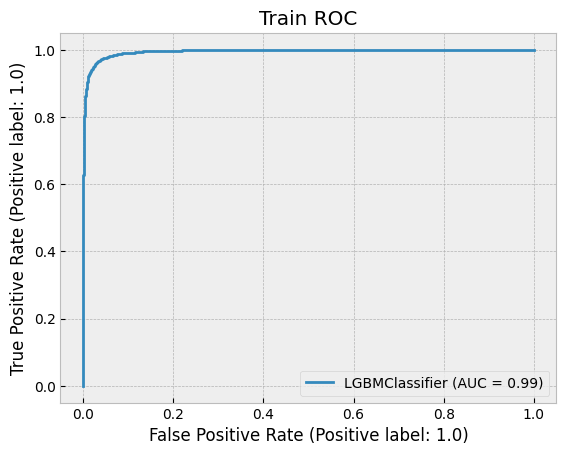

/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


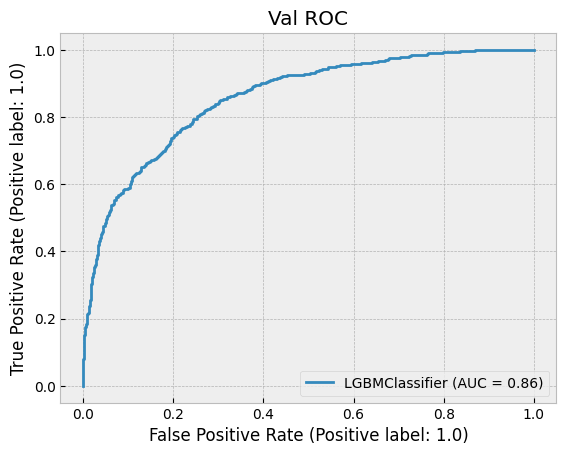

In [22]:
plot_roc_curve(model, X_train, y_train)
plt.title('Train ROC')
plt.show()
plot_roc_curve(model, X_val, y_val)
plt.title('Val ROC')
plt.show()